In [1]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim


# In order to make the import of local modules
import sys
sys.path.append('.')

# local modules
from ultimate_tic_tac_toe_2 import *

100%|██████████| 1000/1000 [07:11<00:00,  2.25it/s]


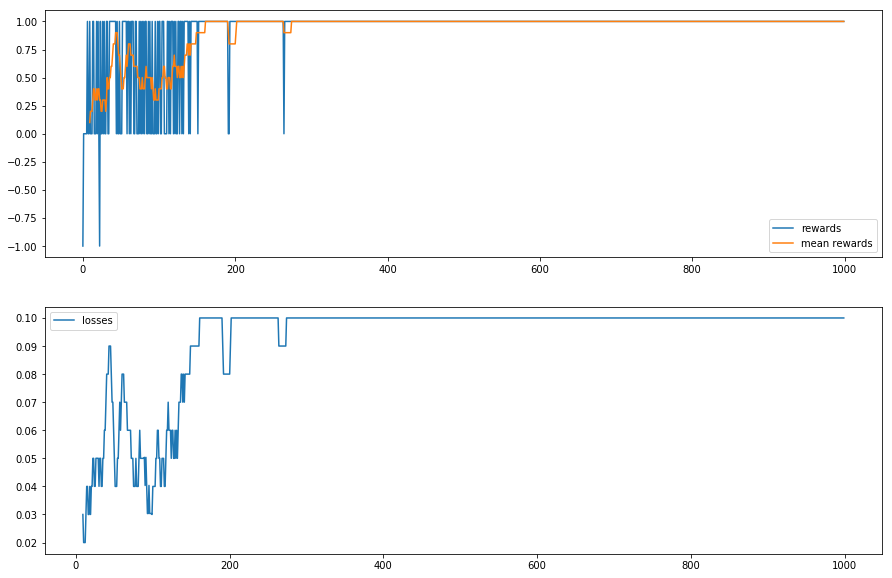

In [27]:
"""
Trying to learn a matrix of weight in order to score a board
"""


class ValueFunction(nn.Module):
    def __init__(self):
        super().__init__()
        # '''
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=3, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=1),
        )
        # '''
        '''
        conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0, stride=3)
        self.fc = nn.Sequential(conv, nn.ReLU(), conv)
        '''

    def forward(self, board_matrix: torch.Tensor) -> torch.Tensor:
        xs = torch.FloatTensor(board_matrix)
        xs = xs.unsqueeze(0).unsqueeze(0)
        return self.fc(xs)


def train(policy: nn.Module, episodes: int):
    rewards = []
    losses = []
    
    adversary_agent = FirstMoveAgent()
    # adversary_agent = RandomAgent()
    # adversary_agent = MinimaxAgent(player=OPPONENT, max_depth=2, eval_fct=CountOwnedEvaluation())

    epsilon = 0.9
    success_count = 0

    criterion = nn.MSELoss()
    optimizer = optim.Adam(policy.parameters(), lr=1e-2)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # for episode in trange(episodes):
    for episode in trange(episodes):
        episode_loss = 0
        episode_reward = 0

        board = Board.empty()
        player_id = PLAYER

        while not board.is_game_over():
            # '''
            if player_id == OPPONENT:
                move = adversary_agent.get_action(board)
                board = board.play(OPPONENT, move)
                player_id = next_player(player_id)
                continue
            # '''

            m = board.as_board_matrix()

            # Find V for current state
            V = policy(m)

            # Choose epsilon-greedy action
            if np.random.rand(1) < epsilon:
                move = random.choice(board.available_moves)
                next_board = board.play(player_id, move)
            else:
                boards = [board.play(player_id, move) for move in board.available_moves]
                # TODO - optimize by stack matrices
                boards.sort(key=lambda b: policy(b.as_board_matrix()).item(), reverse=True if player_id == PLAYER else False)
                next_board = boards[0]

            # TODO - check why it never receives any reward... EVENT WITH RANDOM ADVERSARY...
            
            # Receive next state and reward
            if next_board.winner == PLAYER:
                reward = 1.
                epsilon *= 0.95
            elif next_board.winner == OPPONENT:
                reward = -1.
            else:
                reward = 0.

            # Find max V for t+1 state
            V_target = policy(next_board.as_board_matrix()) + reward

            # Calculate loss & Update policy
            optimizer.zero_grad()
            loss = criterion(V, V_target)
            loss.backward()
            optimizer.step()

            # Record history
            episode_reward += reward
            episode_loss += loss.item()

            # Step forward
            board = next_board
            player_id = next_player(player_id)

        # print(board)
        rewards.append(episode_reward)
        losses.append(episode_loss)

    # print('successful episodes: {:d} - {:.4f}%'.format(success_count, success_count / episodes * 100))

    fig, ax = plt.subplots(figsize=(15, 10), nrows=2)
    ax[0].plot(rewards, label="rewards")
    ax[0].plot(pd.Series(rewards).rolling(10).mean(), label="mean rewards")
    ax[1].plot(pd.Series(losses).rolling(10).sum() / 100., label="losses")
    for p in ax:
        p.legend()
    plt.show()

    
torch.manual_seed(1);
np.random.seed(1)
policy = ValueFunction()
train(policy=policy, episodes=1000)

In [28]:
print(policy)
for param in policy.parameters():
    print(param.data)

ValueFunction(
  (fc): Sequential(
    (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(3, 3), bias=False)
    (1): ReLU()
    (2): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1))
  )
)
tensor([[[[ 0.0591, -0.0155, -0.1966],
          [-0.0399,  0.0378, -0.1980],
          [-0.1295, -0.2851,  0.0316]]]])
tensor([[[[-0.0515,  0.0925,  0.0164],
          [ 0.1217, -0.1299, -0.0243],
          [-0.0300,  0.0483, -0.0013]]]])
tensor([0.2914])
